In [1]:
import pandas
import pyupbit
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Stochastic slow 계산
def calStochastic(df, n, m, t):
    ndays_high = df.high.rolling(window=n, min_periods=1).max()
    ndays_low = df.low.rolling(window=n, min_periods=1).min()
    fast_k = ((df.close - ndays_low) / (ndays_high - ndays_low)) * 100
    slow_k = fast_k.ewm(span=m).mean()
    slow_d = slow_k.ewm(span=t).mean()
    df['slowK'] = slow_k
    df['slowD'] = slow_d
    return df

In [3]:
# 원하는 코인의 stochastic slow 값 가져오기
# 매수 조건, 매도 조건에 따라 거래 시점 표시
def cal_buy_sell(coin="KRW-BTC"):
    df = pyupbit.get_ohlcv(ticker=coin, interval="day", count=1000)
    df = calStochastic(df, 9, 3, 3)
    # 교차 지점에서 slow k가 더 크고, 50미만 일 때 매수
    # 교차 지점에서 slow d가 더 크면 매도
    # if slow_d[-2] > slow_k[-2] and slow_k[-1] > slow_d[-1] and slow_k < 50:
    df['buy'] = np.where((df.slowD.shift(2) > df.slowK.shift(2)) & (df.slowK.shift(1) > df.slowD.shift(1)) & (df.slowK.shift(2) < 50), 1, 0)
    df['sell'] = np.where((df.slowK.shift(2) > df.slowD.shift(2)) & (df.slowD.shift(1) > df.slowK.shift(1)) & (df.slowK.shift(2) > 50), 1, 0)

    return df

In [4]:
# 수익률 계산
def cal_profit(df):
    hold = False
    profit = 1

    buy_signal = []
    sell_signal = []

    for x in df.iterrows():
        if x[1].buy == 1 and hold == False:
            hold = True
            buy_price = x[1].open
            buy_signal.append(buy_price)
            sell_signal.append(np.nan)
        elif x[1].sell == 1 and hold == True:
            hold = False
            sell_price = x[1].open
            sell_signal.append(sell_price)
            buy_signal.append(np.nan)

            # 수익률 누적 곱으로 총 수익률 계산
            profit *= 1 + (sell_price - buy_price) / buy_price
            # print(profit)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)

    df['buy_price'] = buy_signal
    df['sell_price'] = sell_signal

    # print(f'수익률: {profit}')
    # 수수료 빼는 코드 추가하기

    return df, profit

In [5]:
def show_graph(df, coin):
    plt.figure(figsize=(12.2, 4.5))
    plt.plot(df.index, df['open'], alpha=0.5, label='Open Price')
    plt.scatter(df.index, df['buy_price'], color='green', label='Buy Signal', marker='^', alpha=1)
    plt.scatter(df.index, df['sell_price'], color='red', label='Sell Signal', marker='v', alpha=1)
    plt.title(f'{coin} Stochastic Strategy')

    plt.xlabel('Date', fontsize=18)
    plt.xticks(rotation=45)
    plt.ylabel('Price(KRW)', fontsize=18)
    plt.legend(loc='upper left')
    plt.show()

코인: KRW-BTC, 수익률: 2.9041896115281443


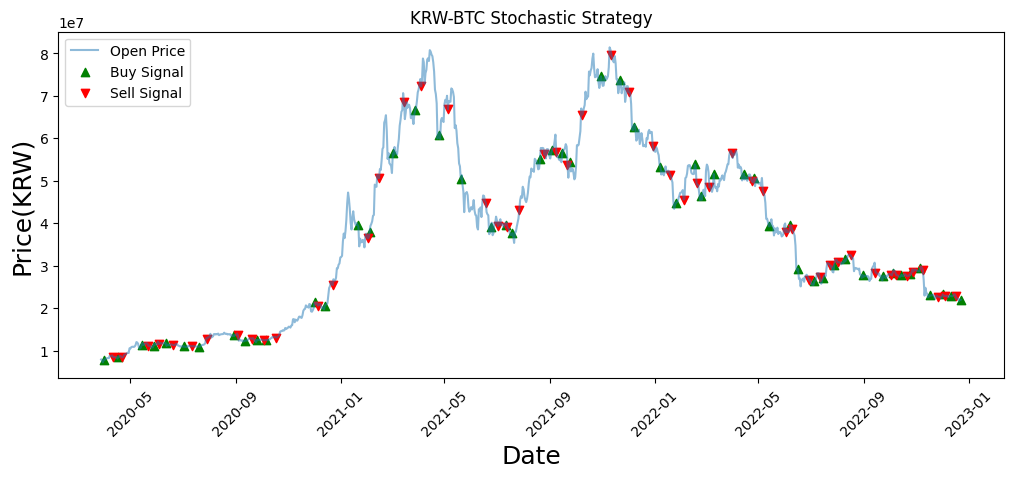

코인: KRW-ETH, 수익률: 2.762918610185187


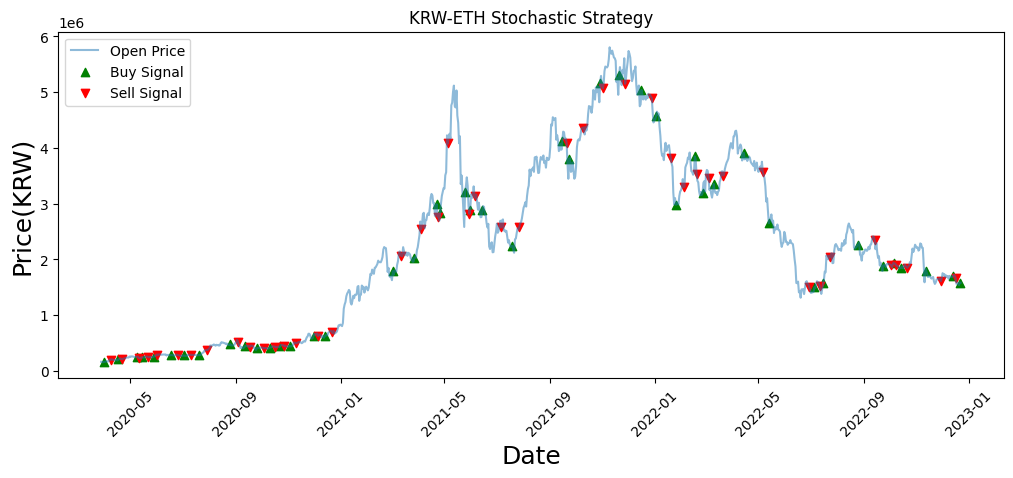

코인: KRW-XRP, 수익률: 0.6878226506849007


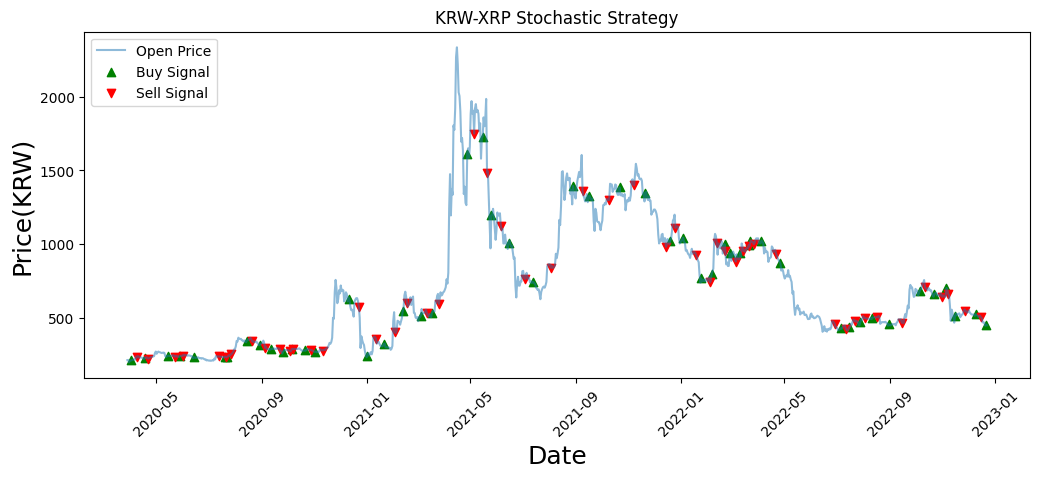

코인: KRW-ADA, 수익률: 2.742423182629124


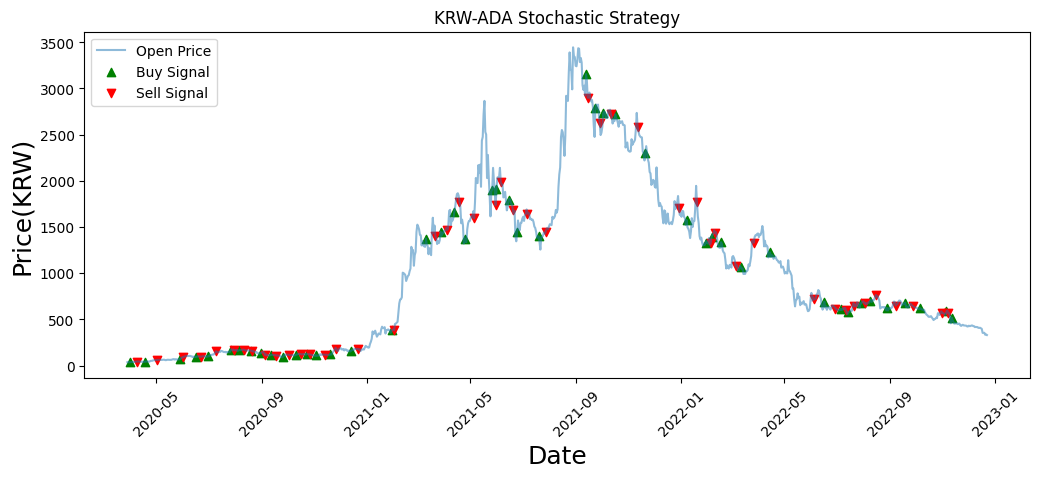

코인: KRW-MATIC, 수익률: 0.8035598885610802


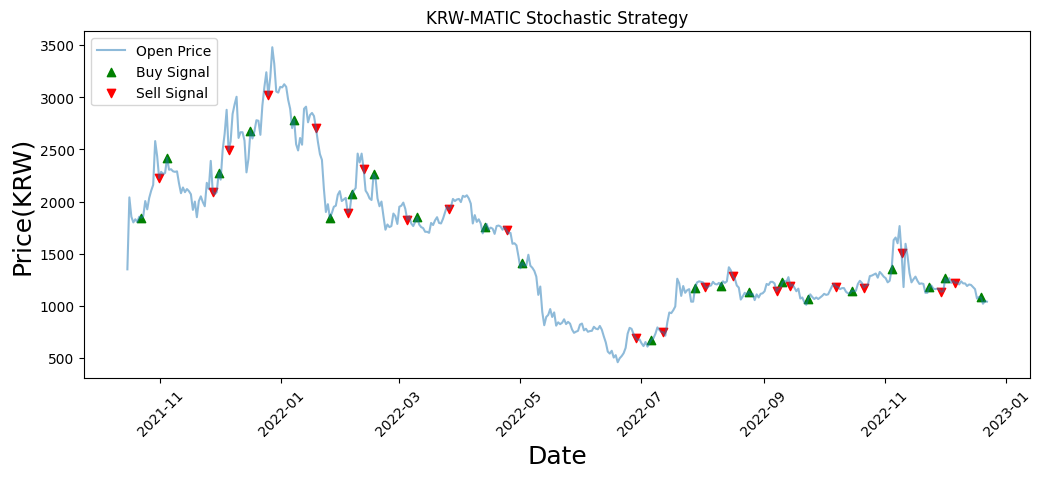

코인: KRW-TRX, 수익률: 3.0658070122385794


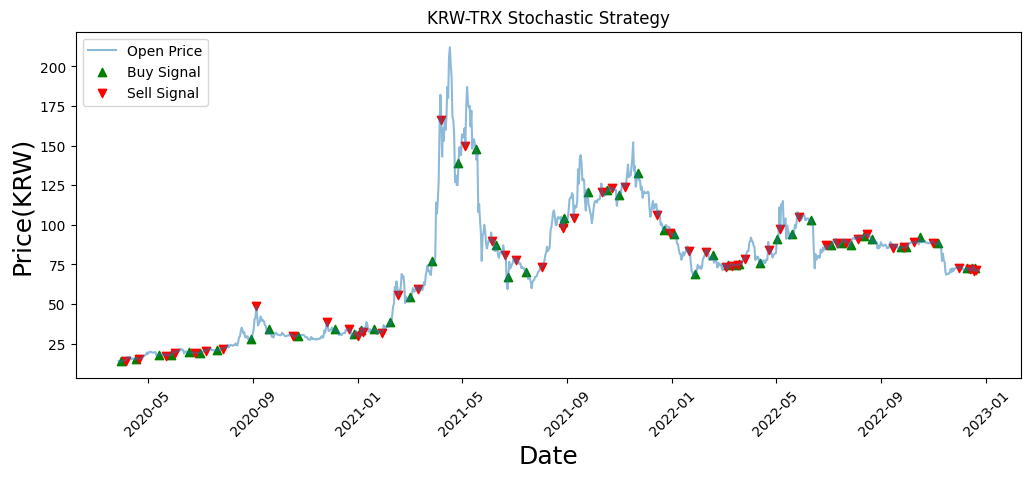

코인: KRW-SOL, 수익률: 0.42275706150890335


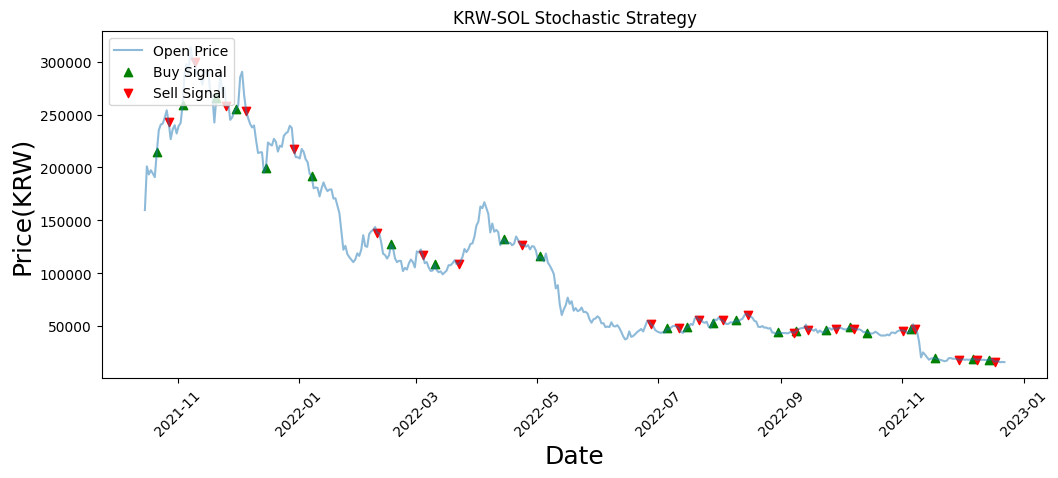

코인: KRW-LINK, 수익률: 1.202488425778652


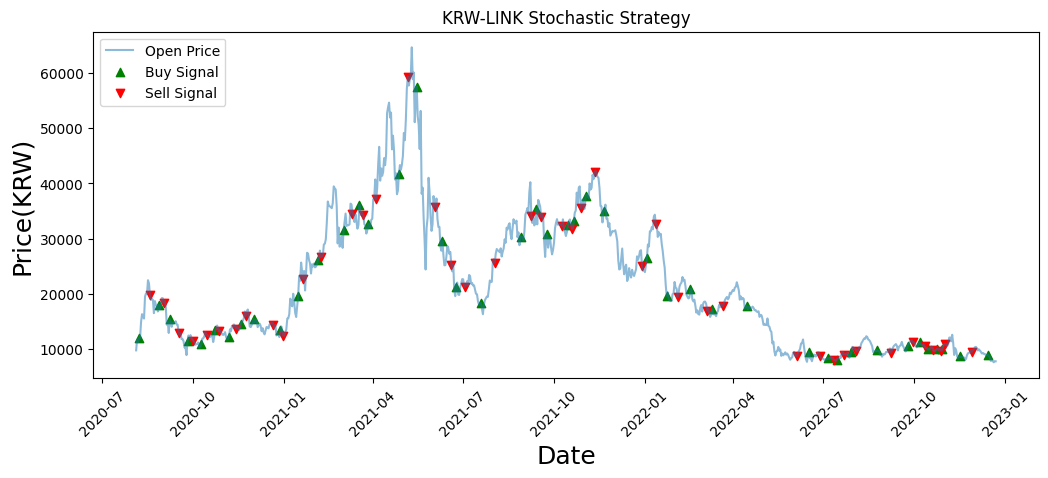

코인: KRW-ETC, 수익률: 13.370972709283377


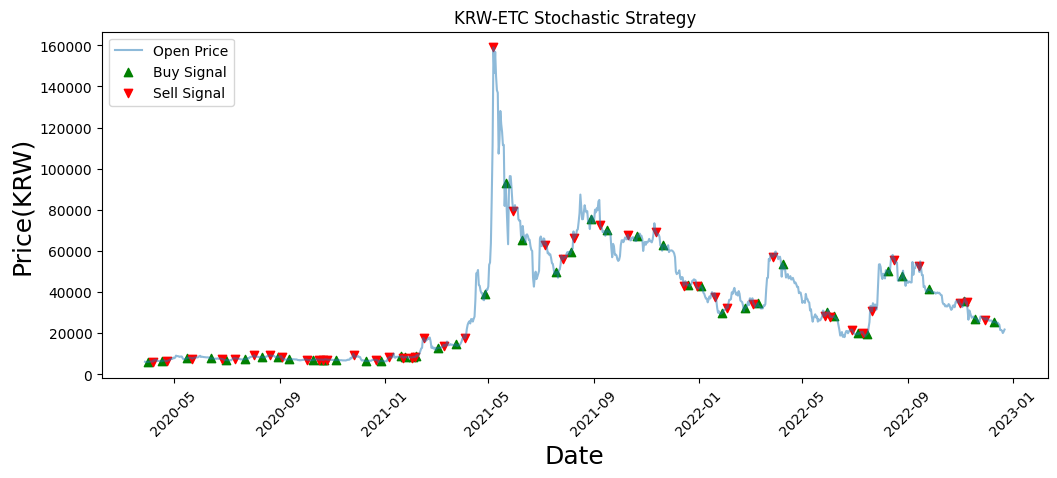

코인: KRW-BCH, 수익률: 0.9398209691084476


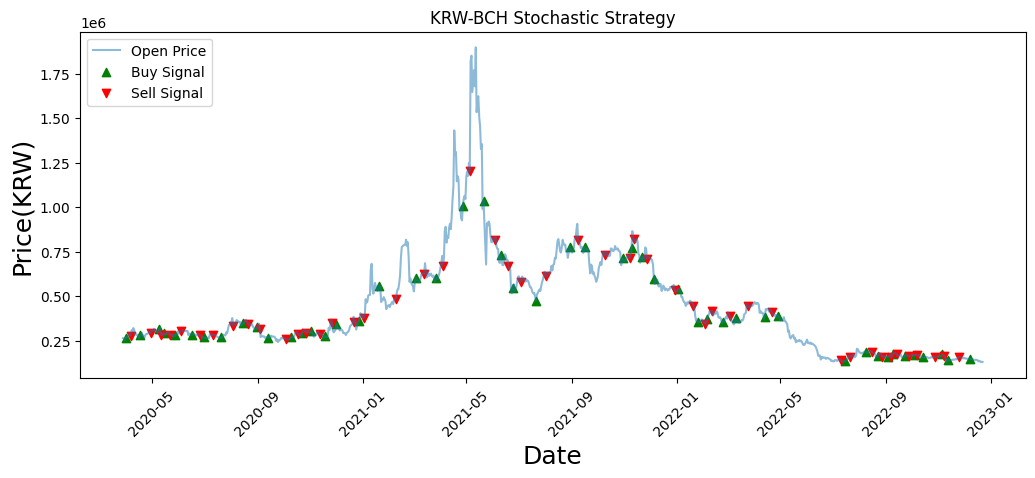

코인: KRW-XLM, 수익률: 2.6596272152859375


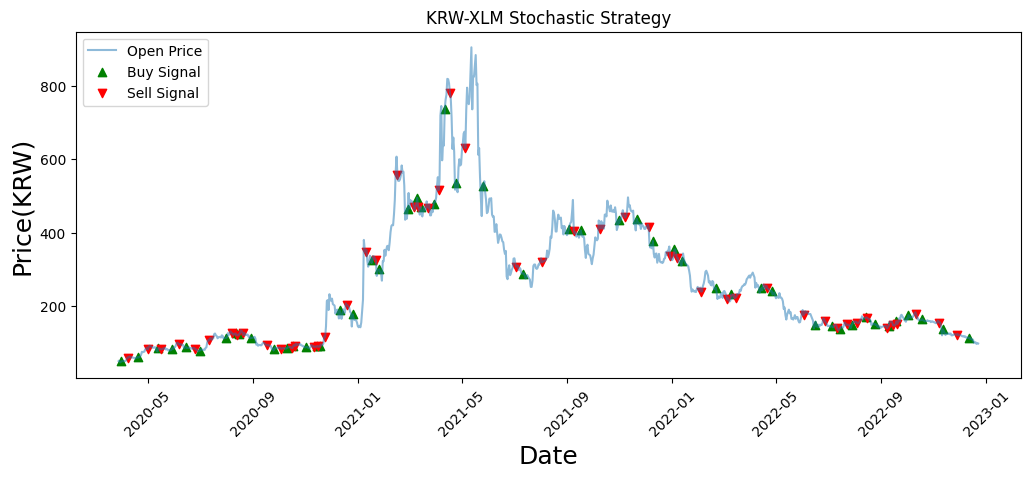

In [6]:
# 테스트할 코인들
coins = ['KRW-BTC', 'KRW-ETH', 'KRW-XRP', 'KRW-ADA', 'KRW-MATIC', 
        'KRW-TRX', 'KRW-SOL', 'KRW-LINK', 'KRW-ETC', 'KRW-BCH', 'KRW-XLM']

for coin in coins:
    df = cal_buy_sell(coin)
    df, profit = cal_profit(df)
    # print(df.head(30))
    print(f'코인: {coin}, 수익률: {profit}')
    show_graph(df, coin)
    # break